In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [40]:
class bandit_prob:
    # Currently only sample average
    '''
    inputs:
        k: number of arms
        probs: probability of random action
        steps: number of iterations
        k_step_counter: counts step for each k arms
        k_reward_avg: sample average of total reward for each k arms
        total_reward_avg: tracks total reward average
        reward_in_each_step: records the reward in each step
        slot_machines: array of each arm. This is represented as a value which will be used in a random number generation
    '''
    def __init__(self, k, probs, steps, technique={'egreedy', 'oiv', 'ucb'}):
        self.k = k
        self.tech = technique
        self.probs = probs            # epsilon
        self.steps = steps            # total steps to do
        self.step_counter = 0         
        self.k_step_counter = [0] * k # N
        
        if technique == 'oiv':
            self.k_expected_reward = [5] * k
        else:
            self.k_expected_reward = [0] * k 
        
        self.total_reward_avg = 0    # avg reward after self.steps
        self.reward_in_each_step = [0] * steps    # records the average reward for that 1 instance
        self.slot_machines = np.random.normal(0, 1, k)    # actual expected value (q*) -----------------------
        self.reward_hist = []
        self.action_hist = []
        self.opt_action_over_steps = []
    
    def special_selection(self):
        expected_modified = []
        for i in range(self.k):
            lnt = np.log(self.step_counter)
            nta = self.k_step_counter[i]
            if nta == 0:
                return i
            c = 0.1
            recency = np.sqrt(lnt / nta) * c
            modified = self.k_expected_reward[i] + recency
            expected_modified.append(modified)
        return np.argmax(expected_modified)
    
    def pull_lever(self): # essentially pulling the lever once
        #choosing action
        p = np.random.rand()
        if p >= self.probs: # choose greedy
            action = np.argmax(self.k_expected_reward)
        elif self.step_counter == 0:
            action = np.random.choice(self.k)
        elif p < self.probs: # choose a random action, explores
            action = np.random.choice(self.k) # returns 0 ~ k - 1
        if self.tech == 'ucb':
            if self.step_counter == 0:
                action = np.random.choice(self.k)
            else:
                action = self.special_selection()
                
        optimal_arm = np.argmax(self.slot_machines)
        if action == optimal_arm:
            self.opt_action_over_steps.append(1)
        else:
            self.opt_action_over_steps.append(0)
        
        
        assert action != None
        selected_machine = self.slot_machines[action]
        reward = np.random.normal(selected_machine, 1) # mean at true value (q*) with variance of 1
        self.reward_hist.append(reward)
        self.action_hist.append(action)
        
        self.k_step_counter[action] += 1
        self.step_counter += 1
       
        
       
        error = (reward - self.k_expected_reward[action])
        step_size = self.k_step_counter[action]
        self.k_expected_reward[action] = self.k_expected_reward[action] + (error / step_size)
        
        self.total_reward_avg = self.total_reward_avg + ((reward - self.total_reward_avg) / self.step_counter)
        
    def pull_step_times(self):
        for i in range(self.steps):
            self.pull_lever()
            self.reward_in_each_step[i] = self.total_reward_avg
    
    def reset(self):
        self.step_counter = 0
        self.k_step_counter = [0] * self.k
        if self.tech == "oiv":
            self.k_expected_reward = [5] * self.k
        else:
            self.k_expected_reward = [0] * self.k
        self.total_reward_avg = 0
        self.reward_in_each_step = [0] * self.steps
        self.reward_hist = []
        self.action_hist = []
        self.opt_action_over_steps = []
        
        
           

In [41]:
#initializing bandit problems.........
e_greedy_bandit = bandit_prob(10, 0.1, 10000, "egreedy")
greedy_bandit = bandit_prob(10, 0, 10000, "greedy")
oiv_bandit = bandit_prob(10, 0.1, 10000, "oiv")
ucb_bandit = bandit_prob(10, 0.1, 10000, "ucb")

entry1 = []
entry2 = []
entry3 = []
entry4 = []

egreed_r = np.zeros((e_greedy_bandit.steps,))
egreed_a = np.zeros((e_greedy_bandit. steps,))
greed_r = np.zeros((greedy_bandit.steps,))
greed_a = np.zeros((greedy_bandit.steps,))
oiv_r = np.zeros((oiv_bandit.steps,))
oiv_a = np.zeros((oiv_bandit.steps,))
ucb_r = np.zeros((ucb_bandit.steps,))
ucb_a = np.zeros((ucb_bandit.steps,))


n_experiments = 2000
for i in range(n_experiments):
    e_greedy_bandit.pull_step_times()
    egreed_r += np.array(e_greedy_bandit.reward_hist)
    entry1.append(e_greedy_bandit.opt_action_over_steps)
    e_greedy_bandit.reset()
    
    greedy_bandit.pull_step_times()
    greed_r += np.array(greedy_bandit.reward_hist)
    entry2.append(greedy_bandit.opt_action_over_steps)
    greedy_bandit.reset()
    
    oiv_bandit.pull_step_times()
    oiv_r += np.array(oiv_bandit.reward_hist)
    entry3.append(oiv_bandit.opt_action_over_steps)
    oiv_bandit.reset()
    
    ucb_bandit.pull_step_times()
    ucb_r += np.array(ucb_bandit.reward_hist)
    entry4.append(ucb_bandit.opt_action_over_steps)
    ucb_bandit.reset()
    
for j in range(len(entry1)):
    egreed_a += entry1[j]
    greed_a += entry2[j]
    oiv_a += entry3[j]
    ucb_a += entry4[j]
    
    
e_greed_r_avg = egreed_r / np.float(n_experiments)
greed_r_avg = greed_r / np.float(n_experiments)
oiv_r_avg = oiv_r / np.float(n_experiments)
ucb_r_avg = ucb_r / np.float(n_experiments)

egreed_a_pct = egreed_a / np.float(n_experiments)
greed_a_pct = greed_a / np.float(n_experiments)
oiv_a_pct = oiv_a / np.float(n_experiments)
ucb_a_pct = ucb_a / np.float(n_experiments)

In [53]:
egreed_a_pct *= 100
greed_a_pct *= 100
oiv_a_pct *= 100
ucb_a_pct *= 100

[  23.   30.   51. ... 1828. 1815. 1822.]


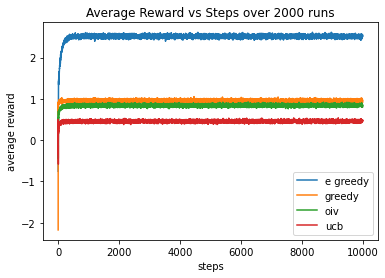

In [42]:
plt.title("Average Reward vs Steps over 2000 runs")
plt.xlabel("steps")
plt.ylabel("average reward")
#width_height_1 = (10, 5)
#plt.figure(figsize=width_height_1)
plt.plot(e_greed_r_avg, label="e greedy")
plt.plot(greed_r_avg, label="greedy")
plt.plot(oiv_r_avg, label="oiv")
plt.plot(ucb_r_avg, label="ucb")
plt.legend()
print(egreed_a)

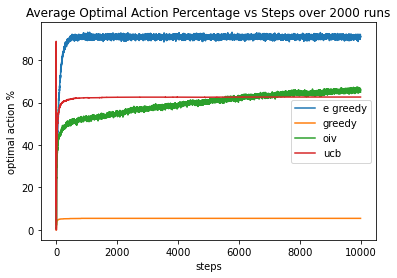

In [54]:
plt.plot(egreed_a_pct, label='e greedy')
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")
plt.title("Average Optimal Action Percentage vs Steps over 2000 runs")
plt.legend()

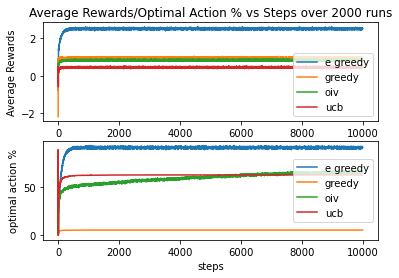

<Figure size 432x288 with 0 Axes>

In [55]:
plt.subplot(2, 1, 1)
plt.plot(e_greed_r_avg, label="e greedy")
plt.plot(greed_r_avg, label="greedy")
plt.plot(oiv_r_avg, label="oiv")
plt.plot(ucb_r_avg, label="ucb")
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(egreed_a_pct, label='e greedy')
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")
plt.legend()
plt.show()

f = plt.figure()
f.set_figheight(4)
plt.show()


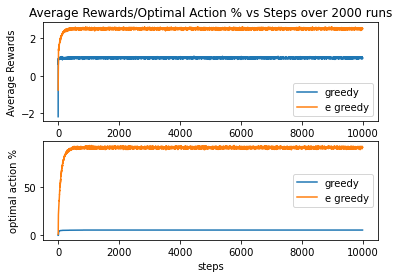

In [56]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(e_greed_r_avg, label='e greedy')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(egreed_a_pct, label='e greedy')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()


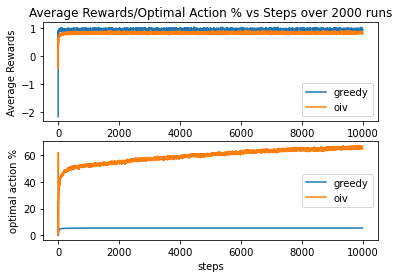

In [57]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(oiv_r_avg, label='oiv')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.xlabel("steps")
plt.ylabel("optimal action %")
plt.legend()


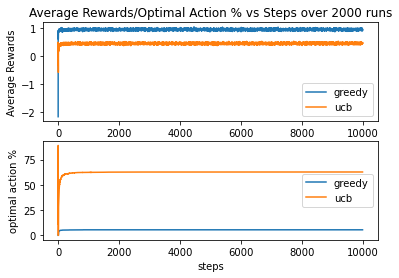

In [58]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(ucb_r_avg, label='ucb')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()


In [59]:
class unstat_bandit_prob:
    # Currently only sample average
    '''
    inputs:
        k: number of arms
        probs: probability of random action
        steps: number of iterations
        k_step_counter: counts step for each k arms
        k_reward_avg: sample average of total reward for each k arms
        total_reward_avg: tracks total reward average
        reward_in_each_step: records the reward in each step
        slot_machines: array of each arm. This is represented as a value which will be used in a random number generation
    '''
    def __init__(self, k, probs, steps, technique):
        self.k = k
        self.probs = probs            # epsilon
        self.steps = steps            # total steps to do
        self.tech = technique
        self.step_counter = 0         
        self.k_step_counter = [0] * k # N
        if technique == 'oiv':
            self.k_expected_reward = [5] * k
        else:
            self.k_expected_reward = [0] * k 
        self.total_reward_avg = 0    # avg reward after self.steps
        self.reward_in_each_step = [0] * steps    # records the average reward for that 1 instance
        self.slot_machines = [0] * k    # actual expected value (q*)
        self.reward_hist = []
        self.action_hist = []
        self.opt_action_over_steps = []
    
    def special_selection(self):
        expected_modified = []
        for i in range(self.k):
            lnt = np.log(self.step_counter)
            nta = self.k_step_counter[i]
            if nta == 0:
                return i
            c = 0.1
            recency = np.sqrt(lnt / nta) * c
            modified = self.k_expected_reward[i] + recency
            expected_modified.append(modified)
        return np.argmax(expected_modified)
    
    def pull_lever(self): # essentially pulling the lever once
        for i in range(len(self.slot_machines)):
            random_walk = np.random.normal(0, 0.01)
            self.slot_machines[i] = self.slot_machines[i] + random_walk
        #print(self.slot_machines)
        
        optimal_arm = np.argmax(self.slot_machines)
            
        p = np.random.rand()
        if p >= self.probs: # choose greedy
            action = np.argmax(self.k_expected_reward)
        elif self.step_counter == 0:
            action = np.random.choice(self.k)
        elif p < self.probs: # choose a random action
            action = np.random.choice(self.k) # returns 0 ~ k - 1
            
        if self.tech == 'ucb':
            if self.step_counter == 0:
                action = np.random.choice(self.k)
            else:
                action = self.special_selection()
            
            
        assert action != None
        
        if action == optimal_arm:
            self.opt_action_over_steps.append(1)
        else: 
            self.opt_action_over_steps.append(0)
        
        selected_machine = self.slot_machines[action]
        reward = np.random.normal(selected_machine, 1) # mean at true value (q*) with variance of 1
        self.reward_hist.append(reward)
        self.action_hist.append(action)
        
        self.k_step_counter[action] += 1
        self.step_counter += 1
    
        error = (reward - self.k_expected_reward[action])
        a = 0.1
        self.k_expected_reward[action] = self.k_expected_reward[action] + ((error) * a)
        
        self.total_reward_avg = self.total_reward_avg + ((reward - self.total_reward_avg) / self.step_counter)
        #random walk on each arm
   
    def pull_step_times(self):
        for i in range(self.steps):
            self.pull_lever()
            self.reward_in_each_step[i] = self.total_reward_avg
    
    def reset(self):
        self.step_counter = 0
        self.k_step_counter = [0] * self.k
        if self.tech == "oiv":
            self.k_expected_reward = [5] * self.k
        else:
            self.k_expected_reward = [0] * self.k
        self.total_reward_avg = 0
        self.reward_in_each_step = [0] * self.steps
        self.slot_machines = [0] * self.k
        self.reward_hist = []
        self.action_hist = []
        self.opt_action_over_steps = []
        
           

In [60]:
e_greedy_bandit = unstat_bandit_prob(10, 0.1, 10000, "egreedy")
greedy_bandit = unstat_bandit_prob(10, 0, 10000, "greedy")
oiv_bandit = unstat_bandit_prob(10, 0.1, 10000, "oiv")
ucb_bandit = unstat_bandit_prob(10, 0.1, 10000, "ucb")

entry1 = []
entry2 = []
entry3 = []
entry4 = []

egreed_r = np.zeros((e_greedy_bandit.steps,))
egreed_a = np.zeros((e_greedy_bandit.steps,))
greed_r = np.zeros((greedy_bandit.steps,))
greed_a = np.zeros((greedy_bandit.steps,))
oiv_r = np.zeros((oiv_bandit.steps,))
oiv_a = np.zeros((oiv_bandit.steps,))
ucb_r = np.zeros((ucb_bandit.steps,))
ucb_a = np.zeros((ucb_bandit.steps,))


n_experiments = 2000
for i in range(n_experiments):
    e_greedy_bandit.pull_step_times()
    egreed_r += np.array(e_greedy_bandit.reward_hist)
    entry1.append(e_greedy_bandit.opt_action_over_steps)
    e_greedy_bandit.reset()
    
    greedy_bandit.pull_step_times()
    greed_r += np.array(greedy_bandit.reward_hist)
    entry2.append(greedy_bandit.opt_action_over_steps)
    greedy_bandit.reset()
    
    oiv_bandit.pull_step_times()
    oiv_r += np.array(oiv_bandit.reward_hist)
    entry3.append(oiv_bandit.opt_action_over_steps)
    oiv_bandit.reset()
    
    ucb_bandit.pull_step_times()
    ucb_r += np.array(ucb_bandit.reward_hist)
    entry4.append(ucb_bandit.opt_action_over_steps)
    ucb_bandit.reset()
    
for j in range(len(entry1)):
    egreed_a += entry1[j]
    greed_a += entry2[j]
    oiv_a += entry3[j]
    ucb_a += entry4[j]
    
e_greed_r_avg = egreed_r / np.float(n_experiments)
greed_r_avg = greed_r / np.float(n_experiments)
oiv_r_avg = oiv_r / np.float(n_experiments)
ucb_r_avg = ucb_r / np.float(n_experiments)

egreed_a_pct = (egreed_a / np.float(n_experiments)) * 100
greed_a_pct = (greed_a / np.float(n_experiments)) * 100
oiv_a_pct = (oiv_a / np.float(n_experiments)) * 100
ucb_a_pct = (ucb_a / np.float(n_experiments)) * 100

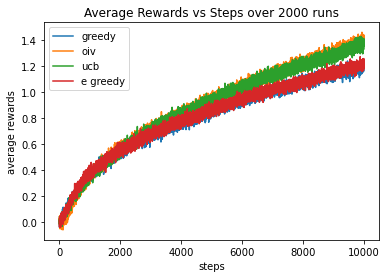

In [67]:

plt.plot(greed_r_avg, label="greedy")
plt.plot(oiv_r_avg, label="oiv")
plt.plot(ucb_r_avg, label="ucb")
plt.plot(e_greed_r_avg, label="e greedy")
plt.xlabel("steps")
plt.title("Average Rewards vs Steps over 2000 runs")
plt.ylabel("average rewards")
plt.legend()
#for i in range(len(e_greed_r_avg)): print(e_greed_r_avg[i])

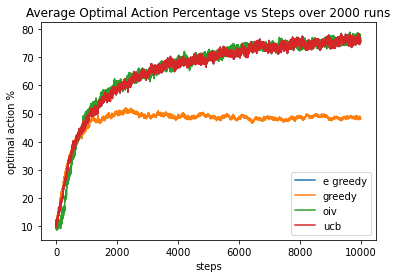

In [68]:
plt.plot(egreed_a_pct, label='e greedy')
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")
plt.title("Average Optimal Action Percentage vs Steps over 2000 runs")
plt.legend()

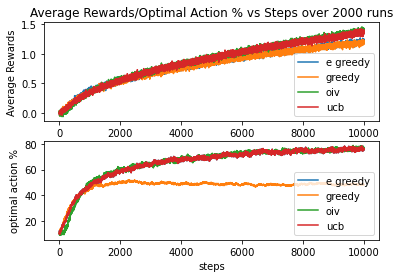

<Figure size 432x288 with 0 Axes>

In [69]:
plt.subplot(2, 1, 1)
plt.plot(e_greed_r_avg, label="e greedy")
plt.plot(greed_r_avg, label="greedy")
plt.plot(oiv_r_avg, label="oiv")
plt.plot(ucb_r_avg, label="ucb")
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(egreed_a_pct, label='e greedy')
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()
plt.show()

f = plt.figure()
f.set_figheight(4)
plt.show()


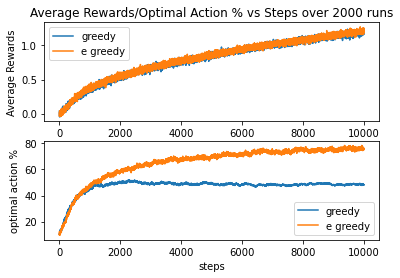

In [70]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(e_greed_r_avg, label='e greedy')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(egreed_a_pct, label='e greedy')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()


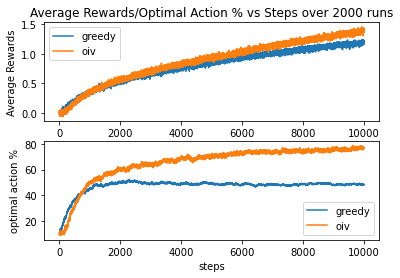

In [71]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(oiv_r_avg, label='oiv')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(oiv_a_pct, label='oiv')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()


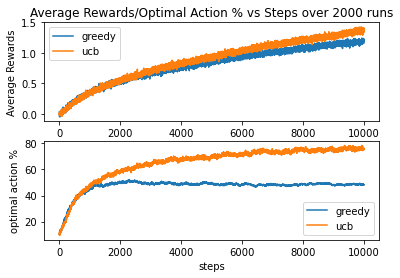

In [72]:
plt.subplot(2, 1, 1)
plt.plot(greed_r_avg, label='greedy')
plt.plot(ucb_r_avg, label='ucb')
plt.ylabel("Average Rewards")
plt.title("Average Rewards/Optimal Action % vs Steps over 2000 runs")
plt.xlabel("steps")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(greed_a_pct, label='greedy')
plt.plot(ucb_a_pct, label='ucb')
plt.xlabel("steps")
plt.ylabel("optimal action %")

plt.legend()
